In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

In [211]:
all_train_data = pd.read_csv('train.csv')
all_test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
all_train_data.dropna(inplace=True)
all_test_data.dropna(inplace=True)

dropped_columns = ['GPA']
y_train = all_train_data['Best Performance']
X_train = all_train_data.drop('Best Performance',axis=1)

#read x_test
for col in dropped_columns:
    X_train = X_train.drop(col,axis=1)
X_test = all_test_data

for col in dropped_columns:
    X_test = X_test.drop(col,axis=1)


In [212]:
X_train.isna().sum()

job_level                                0
job_duration_in_current_job_level        0
person_level                             0
job_duration_in_current_person_level     0
job_duration_in_current_branch           0
Employee_type                            0
gender                                   0
age                                      0
marital_status_maried(Y/N)               0
number_of_dependences                    0
Education_level                          0
year_graduated                           0
job_duration_from_training               0
branch_rotation                          0
job_rotation                             0
assign_of_otherposition                  0
annual leave                             0
sick_leaves                              0
Last_achievement_%                       0
Achievement_above_100%_during3quartal    0
dtype: int64

In [213]:
X_train

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
0,JG04,1.352775,PG03,1.352775,1.732051,RM_type_A,2,1985,Y,1,level_0,2011,4,2,3,2,3,0,46.37,0.0
1,JG04,1.292285,PG03,1.292285,1.039230,RM_type_A,2,1989,Y,0,level_1,2007,4,4,3,0,0,1,47.68,0.0
2,JG05,2.565151,PG06,2.308679,1.780449,RM_type_C,1,1970,Y,1,level_1,1989,28,10,9,6,2,1,40.73,0.0
3,JG05,2.828427,PG06,1.000000,1.385641,RM_type_A,2,1967,Y,2,level_1,1987,29,11,6,0,4,10,47.42,0.0
4,JG05,2.828427,PG06,2.828427,0.707107,RM_type_A,2,1965,Y,3,level_1,1985,30,9,8,2,3,0,47.18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,JG04,1.256981,PG03,1.256981,1.224745,RM_type_A,2,1986,Y,1,level_5,2016,4,3,3,0,4,1,50.87,0.0
11149,JG04,1.385641,PG03,1.385641,1.802776,RM_type_B,1,1988,Y,2,level_5,2015,3,1,2,0,6,0,79.91,0.0
11150,JG04,1.256981,PG03,1.256981,1.385641,RM_type_B,2,1991,Y,0,level_5,2017,2,1,2,0,4,0,78.38,0.0
11151,JG04,1.118034,PG03,1.118034,0.000000,RM_type_A,1,1987,Y,1,level_5,2012,5,5,4,0,4,1,85.94,1.0


In [214]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11152 entries, 0 to 11152
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              11152 non-null  object 
 1   job_duration_in_current_job_level      11152 non-null  float64
 2   person_level                           11152 non-null  object 
 3   job_duration_in_current_person_level   11152 non-null  float64
 4   job_duration_in_current_branch         11152 non-null  float64
 5   Employee_type                          11152 non-null  object 
 6   gender                                 11152 non-null  int64  
 7   age                                    11152 non-null  int64  
 8   marital_status_maried(Y/N)             11152 non-null  object 
 9   number_of_dependences                  11152 non-null  int64  
 10  Education_level                        11152 non-null  object 
 11  ye

In [215]:
# data contain values
cont_col=[col for col in X_train.columns if X_train[col].dtype!='O']
cont_col_test=[col for col in X_test.columns if X_test[col].dtype!='O']
cont_col

['job_duration_in_current_job_level',
 'job_duration_in_current_person_level',
 'job_duration_in_current_branch',
 'gender',
 'age',
 'number_of_dependences',
 'year_graduated',
 'job_duration_from_training',
 'branch_rotation',
 'job_rotation',
 'assign_of_otherposition',
 'annual leave',
 'sick_leaves',
 'Last_achievement_%',
 'Achievement_above_100%_during3quartal']

In [216]:
cont_col_test

['job_duration_in_current_job_level',
 'job_duration_in_current_person_level',
 'job_duration_in_current_branch',
 'gender',
 'age',
 'number_of_dependences',
 'year_graduated',
 'job_duration_from_training',
 'branch_rotation',
 'job_rotation',
 'assign_of_otherposition',
 'annual leave',
 'sick_leaves',
 'Last_achievement_%',
 'Achievement_above_100%_during3quartal']

In [217]:
# data contain category
cat_col=[col for col in X_train.columns if X_train[col].dtype=='O']
cat_col_test=[col for col in X_test.columns if X_test[col].dtype=='O']
cat_col_test

['job_level',
 'person_level',
 'Employee_type',
 'marital_status_maried(Y/N)',
 'Education_level']

In [218]:
categorical=X_train[cat_col]
categorical_test=X_test[cat_col_test]
categorical.head()

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level
0,JG04,PG03,RM_type_A,Y,level_0
1,JG04,PG03,RM_type_A,Y,level_1
2,JG05,PG06,RM_type_C,Y,level_1
3,JG05,PG06,RM_type_A,Y,level_1
4,JG05,PG06,RM_type_A,Y,level_1


In [219]:
#now extract how many categories in each cat_feature
for feature in categorical.columns:
    print('{} has total {} categories \n'.format(feature,len(categorical[feature].value_counts())))
print('---------------------------')
for feature in categorical_test.columns:
    print('{} has total {} categories \n'.format(feature,len(categorical_test[feature].value_counts())))

job_level has total 3 categories 

person_level has total 8 categories 

Employee_type has total 3 categories 

marital_status_maried(Y/N) has total 2 categories 

Education_level has total 6 categories 

---------------------------
job_level has total 4 categories 

person_level has total 7 categories 

Employee_type has total 3 categories 

marital_status_maried(Y/N) has total 2 categories 

Education_level has total 6 categories 



In [220]:
categorical['job_level'].value_counts()

JG04    10412
JG05      704
JG03       36
Name: job_level, dtype: int64

In [221]:
categorical_test['job_level'].value_counts()

JG04    5616
JG05     372
JG03      11
JG06       1
Name: job_level, dtype: int64

In [222]:
categorical['person_level'].value_counts()

PG03    9654
PG04     757
PG06     378
PG05     308
PG07      19
PG01      19
PG02      16
PG08       1
Name: person_level, dtype: int64

In [223]:
categorical_test['person_level'].value_counts()

PG03    5211
PG04     403
PG06     203
PG05     159
PG07      13
PG01       6
PG02       5
Name: person_level, dtype: int64

In [224]:
categorical['marital_status_maried(Y/N)'].value_counts()

Y    9501
N    1651
Name: marital_status_maried(Y/N), dtype: int64

In [225]:
categorical['Education_level'].value_counts()

level_4    9222
level_3    1742
level_1     140
level_5      43
level_2       4
level_0       1
Name: Education_level, dtype: int64

In [20]:
# categorical['marital_status_maried(Y/N)'].unique()

In [226]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
for i in ['job_level', 'person_level', 'Employee_type', 'marital_status_maried(Y/N)','Education_level']:
    categorical[i]=encoder.fit_transform(categorical[i])
    categorical_test[i]=encoder.fit_transform(categorical_test[i])

In [23]:
categorical.info

<bound method DataFrame.info of        job_level  person_level  Employee_type  marital_status_maried(Y/N)  \
0              1             2              0                           1   
1              1             2              0                           1   
2              2             5              2                           1   
3              2             5              0                           1   
4              2             5              0                           1   
...          ...           ...            ...                         ...   
11148          1             2              0                           1   
11149          1             2              1                           1   
11150          1             2              1                           1   
11151          1             2              0                           1   
11152          1             3              1                           1   

       Education_level  
0                 

In [227]:
X_train[cont_col]

,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
0,1.352775,1.352775,1.732051,2,1985,1,2011,4,2,3,2,3,0,46.37,0.0
1,1.292285,1.292285,1.039230,2,1989,0,2007,4,4,3,0,0,1,47.68,0.0
2,2.565151,2.308679,1.780449,1,1970,1,1989,28,10,9,6,2,1,40.73,0.0
3,2.828427,1.000000,1.385641,2,1967,2,1987,29,11,6,0,4,10,47.42,0.0
4,2.828427,2.828427,0.707107,2,1965,3,1985,30,9,8,2,3,0,47.18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,1.256981,1.256981,1.224745,2,1986,1,2016,4,3,3,0,4,1,50.87,0.0
11149,1.385641,1.385641,1.802776,1,1988,2,2015,3,1,2,0,6,0,79.91,0.0
11150,1.256981,1.256981,1.385641,2,1991,0,2017,2,1,2,0,4,0,78.38,0.0
11151,1.118034,1.118034,0.000000,1,1987,1,2012,5,5,4,0,4,1,85.94,1.0


In [228]:
def drop_column(df,col):
    df.drop(col,axis=1,inplace=True)

In [229]:
X_train=pd.concat([categorical,X_train[cont_col]],axis=1)
X_test=pd.concat([categorical_test,X_test[cont_col_test]],axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11152 entries, 0 to 11152
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              11152 non-null  int32  
 1   person_level                           11152 non-null  int32  
 2   Employee_type                          11152 non-null  int32  
 3   marital_status_maried(Y/N)             11152 non-null  int32  
 4   Education_level                        11152 non-null  int32  
 5   job_duration_in_current_job_level      11152 non-null  float64
 6   job_duration_in_current_person_level   11152 non-null  float64
 7   job_duration_in_current_branch         11152 non-null  float64
 8   gender                                 11152 non-null  int64  
 9   age                                    11152 non-null  int64  
 10  number_of_dependences                  11152 non-null  int64  
 11  ye

In [230]:
X_test.head()

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
0,1,2,0,0,3,1.256981,1.256981,0.707107,1,1988,0,2009,6,4,2,6,3,7,84.02,0.0
1,1,2,1,0,4,1.224745,1.224745,1.256981,2,1991,0,2014,2,2,2,0,1,0,63.74,0.0
2,1,2,0,1,4,0.500000,0.500000,1.081665,2,1989,1,2011,4,2,2,0,2,1,88.19,1.0
3,1,2,0,1,4,1.256981,1.256981,1.802776,2,1990,1,2014,3,1,3,0,3,0,25.94,0.0
4,1,2,1,1,4,1.352775,1.352775,1.224745,1,1985,0,2007,5,3,2,0,3,0,82.32,0.0


In [231]:
tahun = 2020
X_train['age'] = tahun - X_train['age']
X_test['age'] = tahun - X_test['age']


In [27]:
X_train['age'].value_counts()

32    1558
33    1473
34    1348
31    1323
35     954
30     926
36     654
29     510
37     472
38     286
39     240
40     228
28     192
41     154
42     121
43      92
44      73
45      55
27      55
46      47
47      45
52      44
51      41
50      38
49      38
53      35
48      35
56      29
55      27
54      25
26      16
25       7
57       6
24       4
23       1
Name: age, dtype: int64

# Feature Correlation

[0.00347461 0.00622998 0.02154354 0.00974067 0.02738642 0.07170922
 0.07209551 0.07932396 0.01084572 0.08239044 0.04137736 0.07858549
 0.06274619 0.06154614 0.05655867 0.05138815 0.08111962 0.05930907
 0.09542224 0.027207  ]


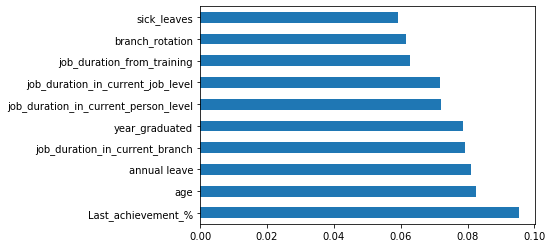

In [232]:

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [233]:
num_feats= len(X_train.columns)
print(num_feats)

20


In [234]:
# drop_column(X_train,'job_level')
# drop_column(X_train,'person_level')
# drop_column(X_train,'marital_status_maried(Y/N)')
# drop_column(X_train,'Employee_type')
# drop_column(X_train,'Achievement_above_100%_during3quartal')
# drop_column(X_train,'Education_level')

# drop_column(X_test,'job_level')
# drop_column(X_test,'person_level')
# drop_column(X_test,'marital_status_maried(Y/N)')
# drop_column(X_test,'Employee_type')
# drop_column(X_test,'Achievement_above_100%_during3quartal')
# drop_column(X_test,'Education_level')

In [235]:
# cat_columns = ['job_level', 'person_level', 'Employee_type', 'marital_status_maried(Y/N)', 'Education_level', 'Employee_type']
# for cat in cat_columns:
#     labelencoder = LabelEncoder()
#     X_train_[cat] = labelencoder.fit_transform(X_train_[cat].astype(str))
#     X_test_[cat] = labelencoder.transform(X_test_[cat].astype(str))       
    

In [236]:

#split x_train and x_val
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=38)


In [237]:
X_train_

,job_level,person_level,Employee_type,marital_status_maried(Y/N),Education_level,job_duration_in_current_job_level,job_duration_in_current_person_level,job_duration_in_current_branch,gender,age,number_of_dependences,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal
9630,1,2,1,1,4,1.191638,1.191638,1.352775,1,32,2,2012,2,1,2,0,3,0,13.16,0.0
5422,1,2,0,1,4,1.292285,1.292285,0.707107,2,33,1,2010,6,3,4,3,0,0,97.15,3.0
2658,1,2,0,1,4,1.191638,1.191638,0.707107,1,32,0,2012,5,3,2,0,6,2,38.56,0.0
3330,1,2,1,1,4,1.256981,1.256981,1.224745,1,33,1,2009,6,3,4,0,2,5,95.58,3.0
5239,1,2,1,1,4,1.352775,1.352775,1.191638,2,38,1,2011,6,3,4,0,1,0,108.39,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,1,3,0,1,4,2.345208,1.581139,0.000000,2,43,3,2002,16,7,7,22,9,0,94.40,2.0
10978,2,5,0,1,4,2.828427,2.828427,0.412311,1,53,3,2003,30,14,9,0,2,0,64.91,0.0
5379,1,2,1,0,4,1.224745,1.224745,1.118034,2,31,0,2014,3,2,2,0,8,2,61.68,0.0
4413,1,2,0,1,4,1.322876,1.322876,1.118034,1,34,0,2010,6,3,5,2,7,1,110.56,3.0


# LGBM

In [238]:
class lgbm_target :
    def __init__(self, x_train, y_train, x_test, y_test) :
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
    def clean_param(self, param) :
        params = {'boosting_type':'gbdt', 'class_weight':None, 'colsample_bytree':1.0, 
                  'importance_type':'split', 'learning_rate':0.1,
                  'min_child_samples':2000, 'min_split_gain':0.0, 'n_estimators':10, 'objective':None,
                  'random_state':0, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
                  'subsample':1.0, 'subsample_for_bin':200000, 'subsample_freq':0}
        params['num_leaves'] = int(param['num_leaves'])
        params['min_child_weight'] = int(param['min_child_weight'])
        params['max_depth'] = int(param['max_depth'])
        params['learning_rate'] = 0.1
        params['min_data_in_bin'] = 1
        params['min_data'] = 1
        
        params['min_child_samples'] = int(param['min_child_samples'])
        params['bagging_fraction'] = param['bagging_fraction']
        params['lambda_l1'] = param['lambda_l1']
        params['lambda_l2'] = param['lambda_l2']

        return params
        
    def evaluate(self, min_child_weight, max_depth, num_leaves,
                min_child_samples, bagging_fraction, lambda_l1, lambda_l2):
        params = {'num_leaves':num_leaves, 
                  'min_child_weight':min_child_weight, 
                  'max_depth':max_depth,
                 'min_child_samples':min_child_samples,
                 'bagging_fraction' : bagging_fraction,
                 'lambda_l1' : lambda_l1,
                 'lambda_l2' : lambda_l2}
        
        params = self.clean_param(params)
        res=[]
        lgbm_model = lgb.LGBMClassifier(**params)
        lgbm_model.fit(self.x_train, self.y_train)
        y_pred = lgbm_model.predict_proba(self.x_test)
        predictions = y_pred[:,1]
        res.append(predictions)
        acc = roc_auc_score(self.y_test,predictions)
        print('######',acc)
        return acc


lt = lgbm_target(X_train_, y_train_, X_test_, y_test_)
lgbmBO = BayesianOptimization(lt.evaluate, {'min_child_weight': (0.01, 1),
                                              'max_depth': (7, 25),
                                              'num_leaves': (5, 50),
                                            'min_child_samples' :(10,50),
                                            'bagging_fraction' : (0.5,1),
                                            'lambda_l1' : (0,1),
                                            'lambda_l2' : (0,1)
                                           }, 
                             random_state=3)

lgbmBO.maximize(init_points=10, n_iter=55)

|   iter    |  target   | baggin... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=45, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.7081478226181048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7081478226181048
[LightGBM] [Warning] bagging_fraction is set=0.7753989512872878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753989512872878
[LightGBM] [Warning] lambda_l2 is set=0.2909047389129443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2909047389129443
###### 0.5721569591139208
|  1        |  0.5722   |  0.7754   |  0.7081   |  0.2909   |  16.19    |  45.72    |  0.8973   |  10.65    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=28, will be overridden

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=24, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
###### 0.5897033125176676
|  12       |  0.5897   |  0.5      |  1.0      |  0.0      |  22.68    |  24.83    |  0.01     |  24.8     |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=18, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1.

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=24, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.3212230531029492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3212230531029492
[LightGBM] [Warning] bagging_fraction is set=0.8849891647860483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849891647860483
[LightGBM] [Warning] lambda_l2 is set=0.4318537432393089, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4318537432393089
###### 0.5843379783105903
|  24       |  0.5843   |  0.885    |  0.3212   |  0.4319   |  23.64    |  24.81    |  0.05524  |  25.26    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=22, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.9217182645054827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9217182645054827
[LightGBM] [Warning] bagging_fraction

|  35       |  0.5938   |  0.8671   |  0.4119   |  0.9003   |  14.06    |  37.97    |  0.5822   |  25.63    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=34, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.5271951377535574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5271951377535574
[LightGBM] [Warning] bagging_fraction is set=0.6203273979892842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6203273979892842
[LightGBM] [Warning] lambda_l2 is set=0.3363607305952947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3363607305952947
###### 0.5752801120448179
|  36       |  0.5753   |  0.6203   |  0.5272   |  0.3364   |  13.4     |  34.45    |  0.4004   |  43.02    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=14, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.3986526074949298, re

|  47       |  0.5814   |  0.6833   |  0.2518   |  0.316    |  8.071    |  32.1     |  0.6138   |  5.064    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=28, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.3738860946939825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3738860946939825
[LightGBM] [Warning] bagging_fraction is set=0.5672381099554892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5672381099554892
[LightGBM] [Warning] lambda_l2 is set=0.18862213646524562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18862213646524562
###### 0.5799250893017758
|  48       |  0.5799   |  0.5672   |  0.3739   |  0.1886   |  18.97    |  28.17    |  0.3967   |  44.76    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=30, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.8282125118780956, 

|  58       |  0.5804   |  0.7856   |  0.6992   |  0.02534  |  18.26    |  20.84    |  0.6277   |  36.55    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=46, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.729613397447639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.729613397447639
[LightGBM] [Warning] bagging_fraction is set=0.6942898608630226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6942898608630226
[LightGBM] [Warning] lambda_l2 is set=0.06505923286507975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06505923286507975
###### 0.5771360149564413
|  59       |  0.5771   |  0.6943   |  0.7296   |  0.06506  |  24.78    |  46.37    |  0.3293   |  19.93    |
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=21, will be overridden by min_data=1. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.35010104423236943, r

In [242]:
b=lgbmBO.max['params']
print(b)

{'bagging_fraction': 0.8670618214627952, 'lambda_l1': 0.41190034873180104, 'lambda_l2': 0.9002751065225565, 'max_depth': 14.056973059841404, 'min_child_samples': 37.97327751500377, 'min_child_weight': 0.5822193880397624, 'num_leaves': 25.62711582354824}


|   iter    |  target   | baggin... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_ch... | num_le... |

In [240]:
params = {'min_child_weight': b['min_child_weight'],
              'max_depth': round(b['max_depth']),
              'num_leaves': round(b['num_leaves']),
            'min_child_samples' :round(b['min_child_samples']),
            'bagging_fraction' : b['bagging_fraction'],
            'lambda_l1' : b['lambda_l1'],
            'lambda_l2' : b['lambda_l2']
           }
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train,y_train)
model_lgb.predict_proba(X_test)[:,1]
sample_submission['Best Performance'] = model_lgb.predict_proba(X_test)[:,1]
# sample_submission.to_csv('submission.csv')

[LightGBM] [Warning] lambda_l1 is set=0.41190034873180104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41190034873180104
[LightGBM] [Warning] bagging_fraction is set=0.8670618214627952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8670618214627952
[LightGBM] [Warning] lambda_l2 is set=0.9002751065225565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9002751065225565


In [241]:
'''ADVERSARIAL VALIDATION'''
y_label_adv = np.zeros((X_train.shape[0]+ X_test.shape[0]))
y_label_adv[:X_train.shape[0]] = 1
adversarial_data = pd.concat((X_train,X_test))
# model_lgb = lgb.LGBMClassifier()
X_train_, X_test_, y_train_, y_test_ = train_test_split(adversarial_data, y_label_adv, test_size=0.33, random_state=38)

model_lgb.fit(X_train_,y_train_)
y_pred  = model_lgb.predict(X_test_)
roc_auc_score(y_pred,y_test_)

[LightGBM] [Warning] lambda_l1 is set=0.41190034873180104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41190034873180104
[LightGBM] [Warning] bagging_fraction is set=0.8670618214627952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8670618214627952
[LightGBM] [Warning] lambda_l2 is set=0.9002751065225565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9002751065225565


0.48831959631265304

In [201]:
'''0.55 acc'''
params = {'min_child_weight': 0.6715,
              'max_depth': 12,
              'num_leaves': 20,
            'min_child_samples' :24,
            'bagging_fraction' : 0.8538,
            'lambda_l1' : 0.7467,
            'lambda_l2' : 0.6911
           }
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train,y_train)
model_lgb.predict_proba(X_test)[:,1]
sample_submission['Best Performance'] = model_lgb.predict_proba(X_test)[:,1]
# sample_submission.to_csv('submission.csv')

[LightGBM] [Warning] lambda_l1 is set=0.7467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7467
[LightGBM] [Warning] bagging_fraction is set=0.8538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8538
[LightGBM] [Warning] lambda_l2 is set=0.6911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6911


In [80]:
'''0.55 acc-modified'''
params = {'min_child_weight': 0.5,
              'max_depth': 12,
              'num_leaves': 20,
            'min_child_samples' :24,
            'bagging_fraction' : 0.7,
            'lambda_l1' : 0.746,
            'lambda_l2' : 0.6
           }
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train,y_train)
model_lgb.predict_proba(X_test)[:,1]
sample_submission['Best Performance'] = model_lgb.predict_proba(X_test)[:,1]
# sample_submission.to_csv('submission.csv')

[LightGBM] [Warning] lambda_l1 is set=0.746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.746
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6


In [82]:
y_label_adv.shape

(17152,)

In [83]:
sample_submission

,index,Best Performance
0,0,0.122179
1,1,0.118160
2,2,0.414449
3,3,0.100791
4,4,0.115633
...,...,...
5995,5995,0.111780
5996,5996,0.062304
5997,5997,0.240500
5998,5998,0.169716


In [84]:
sample_submission.to_csv('submission_54.csv', index=False)

# CatBoost

In [243]:

from catboost import Pool, CatBoostClassifier, cv
cate_features_index = np.where(X_train.dtypes != float)[0] 
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=38)


In [244]:
model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=42)

In [246]:
model.fit(X_train_, y_train_, cat_features=cate_features_index,eval_set=(X_test_, y_test_))


0:	test: 0.4882880	best: 0.4882880 (0)	total: 46.5ms	remaining: 1m 9s
1:	test: 0.5009043	best: 0.5009043 (1)	total: 80.5ms	remaining: 1m
2:	test: 0.5083142	best: 0.5083142 (2)	total: 117ms	remaining: 58.2s
3:	test: 0.5152977	best: 0.5152977 (3)	total: 132ms	remaining: 49.3s
4:	test: 0.5479852	best: 0.5479852 (4)	total: 180ms	remaining: 53.9s
5:	test: 0.5470922	best: 0.5479852 (4)	total: 195ms	remaining: 48.7s
6:	test: 0.5485908	best: 0.5485908 (6)	total: 222ms	remaining: 47.4s
7:	test: 0.5439080	best: 0.5485908 (6)	total: 278ms	remaining: 51.8s
8:	test: 0.5444132	best: 0.5485908 (6)	total: 320ms	remaining: 53s
9:	test: 0.5444132	best: 0.5485908 (6)	total: 331ms	remaining: 49.3s
10:	test: 0.5439956	best: 0.5485908 (6)	total: 348ms	remaining: 47.1s
11:	test: 0.5456371	best: 0.5485908 (6)	total: 394ms	remaining: 48.8s
12:	test: 0.5431339	best: 0.5485908 (6)	total: 444ms	remaining: 50.8s
13:	test: 0.5431339	best: 0.5485908 (6)	total: 456ms	remaining: 48.4s
14:	test: 0.5430809	best: 0.54859

123:	test: 0.5416466	best: 0.5485908 (6)	total: 3.38s	remaining: 37.5s
124:	test: 0.5422055	best: 0.5485908 (6)	total: 3.4s	remaining: 37.4s
125:	test: 0.5423437	best: 0.5485908 (6)	total: 3.42s	remaining: 37.3s
126:	test: 0.5420369	best: 0.5485908 (6)	total: 3.45s	remaining: 37.3s
127:	test: 0.5420369	best: 0.5485908 (6)	total: 3.46s	remaining: 37.1s
128:	test: 0.5410363	best: 0.5485908 (6)	total: 3.49s	remaining: 37.1s
129:	test: 0.5410363	best: 0.5485908 (6)	total: 3.5s	remaining: 36.9s
130:	test: 0.5410363	best: 0.5485908 (6)	total: 3.51s	remaining: 36.7s
131:	test: 0.5410363	best: 0.5485908 (6)	total: 3.52s	remaining: 36.5s
132:	test: 0.5409270	best: 0.5485908 (6)	total: 3.54s	remaining: 36.4s
133:	test: 0.5425428	best: 0.5485908 (6)	total: 3.58s	remaining: 36.5s
134:	test: 0.5425316	best: 0.5485908 (6)	total: 3.61s	remaining: 36.5s
135:	test: 0.5418666	best: 0.5485908 (6)	total: 3.66s	remaining: 36.7s
136:	test: 0.5418666	best: 0.5485908 (6)	total: 3.67s	remaining: 36.6s
137:	tes

239:	test: 0.5598346	best: 0.5644033 (205)	total: 6.85s	remaining: 36s
240:	test: 0.5599647	best: 0.5644033 (205)	total: 6.88s	remaining: 35.9s
241:	test: 0.5582477	best: 0.5644033 (205)	total: 6.93s	remaining: 36s
242:	test: 0.5582477	best: 0.5644033 (205)	total: 6.94s	remaining: 35.9s
243:	test: 0.5597222	best: 0.5644033 (205)	total: 6.99s	remaining: 36s
244:	test: 0.5614070	best: 0.5644033 (205)	total: 7.04s	remaining: 36.1s
245:	test: 0.5614070	best: 0.5644033 (205)	total: 7.06s	remaining: 36s
246:	test: 0.5625490	best: 0.5644033 (205)	total: 7.11s	remaining: 36.1s
247:	test: 0.5624285	best: 0.5644033 (205)	total: 7.16s	remaining: 36.2s
248:	test: 0.5624285	best: 0.5644033 (205)	total: 7.17s	remaining: 36s
249:	test: 0.5624285	best: 0.5644033 (205)	total: 7.18s	remaining: 35.9s
250:	test: 0.5624735	best: 0.5644033 (205)	total: 7.21s	remaining: 35.9s
251:	test: 0.5620069	best: 0.5644033 (205)	total: 7.26s	remaining: 36s
252:	test: 0.5623346	best: 0.5644033 (205)	total: 7.29s	remaini

358:	test: 0.5672333	best: 0.5672333 (358)	total: 11.9s	remaining: 37.9s
359:	test: 0.5672735	best: 0.5672735 (359)	total: 12s	remaining: 37.9s
360:	test: 0.5671498	best: 0.5672735 (359)	total: 12s	remaining: 37.9s
361:	test: 0.5671498	best: 0.5672735 (359)	total: 12s	remaining: 37.8s
362:	test: 0.5669522	best: 0.5672735 (359)	total: 12.1s	remaining: 37.9s
363:	test: 0.5666920	best: 0.5672735 (359)	total: 12.1s	remaining: 37.9s
364:	test: 0.5670647	best: 0.5672735 (359)	total: 12.2s	remaining: 37.9s
365:	test: 0.5666439	best: 0.5672735 (359)	total: 12.3s	remaining: 38s
366:	test: 0.5670438	best: 0.5672735 (359)	total: 12.3s	remaining: 38s
367:	test: 0.5668237	best: 0.5672735 (359)	total: 12.4s	remaining: 38s
368:	test: 0.5670486	best: 0.5672735 (359)	total: 12.4s	remaining: 38.1s
369:	test: 0.5675064	best: 0.5675064 (369)	total: 12.4s	remaining: 38s
370:	test: 0.5672606	best: 0.5675064 (369)	total: 12.5s	remaining: 38s
371:	test: 0.5672783	best: 0.5675064 (369)	total: 12.5s	remaining: 

473:	test: 0.5701388	best: 0.5703380 (448)	total: 18s	remaining: 38.9s
474:	test: 0.5703492	best: 0.5703492 (474)	total: 18s	remaining: 38.9s
475:	test: 0.5701806	best: 0.5703492 (474)	total: 18.1s	remaining: 38.9s
476:	test: 0.5700826	best: 0.5703492 (474)	total: 18.1s	remaining: 38.9s
477:	test: 0.5698032	best: 0.5703492 (474)	total: 18.2s	remaining: 38.9s
478:	test: 0.5695783	best: 0.5703492 (474)	total: 18.2s	remaining: 38.9s
479:	test: 0.5695879	best: 0.5703492 (474)	total: 18.3s	remaining: 38.9s
480:	test: 0.5695044	best: 0.5703492 (474)	total: 18.3s	remaining: 38.9s
481:	test: 0.5695140	best: 0.5703492 (474)	total: 18.4s	remaining: 38.8s
482:	test: 0.5694305	best: 0.5703492 (474)	total: 18.4s	remaining: 38.8s
483:	test: 0.5695157	best: 0.5703492 (474)	total: 18.5s	remaining: 38.8s
484:	test: 0.5695526	best: 0.5703492 (474)	total: 18.6s	remaining: 38.8s
485:	test: 0.5696457	best: 0.5703492 (474)	total: 18.6s	remaining: 38.8s
486:	test: 0.5696457	best: 0.5703492 (474)	total: 18.6s

588:	test: 0.5715458	best: 0.5715458 (588)	total: 24.3s	remaining: 37.6s
589:	test: 0.5716823	best: 0.5716823 (589)	total: 24.4s	remaining: 37.6s
590:	test: 0.5716326	best: 0.5716823 (589)	total: 24.4s	remaining: 37.6s
591:	test: 0.5717530	best: 0.5717530 (591)	total: 24.5s	remaining: 37.6s
592:	test: 0.5713001	best: 0.5717530 (591)	total: 24.6s	remaining: 37.6s
593:	test: 0.5712278	best: 0.5717530 (591)	total: 24.7s	remaining: 37.6s
594:	test: 0.5718654	best: 0.5718654 (594)	total: 24.7s	remaining: 37.6s
595:	test: 0.5718895	best: 0.5718895 (595)	total: 24.8s	remaining: 37.6s
596:	test: 0.5718831	best: 0.5718895 (595)	total: 24.8s	remaining: 37.5s
597:	test: 0.5718478	best: 0.5718895 (595)	total: 24.9s	remaining: 37.6s
598:	test: 0.5717337	best: 0.5718895 (595)	total: 25s	remaining: 37.6s
599:	test: 0.5717771	best: 0.5718895 (595)	total: 25s	remaining: 37.6s
600:	test: 0.5718960	best: 0.5718960 (600)	total: 25.1s	remaining: 37.6s
601:	test: 0.5720180	best: 0.5720180 (601)	total: 25.2s

704:	test: 0.5695735	best: 0.5731327 (606)	total: 30.7s	remaining: 34.6s
705:	test: 0.5695285	best: 0.5731327 (606)	total: 30.8s	remaining: 34.6s
706:	test: 0.5696682	best: 0.5731327 (606)	total: 30.9s	remaining: 34.6s
707:	test: 0.5697999	best: 0.5731327 (606)	total: 30.9s	remaining: 34.6s
708:	test: 0.5695960	best: 0.5731327 (606)	total: 31s	remaining: 34.6s
709:	test: 0.5695976	best: 0.5731327 (606)	total: 31.1s	remaining: 34.6s
710:	test: 0.5696313	best: 0.5731327 (606)	total: 31.1s	remaining: 34.5s
711:	test: 0.5694819	best: 0.5731327 (606)	total: 31.2s	remaining: 34.5s
712:	test: 0.5692892	best: 0.5731327 (606)	total: 31.2s	remaining: 34.5s
713:	test: 0.5692298	best: 0.5731327 (606)	total: 31.3s	remaining: 34.4s
714:	test: 0.5691800	best: 0.5731327 (606)	total: 31.3s	remaining: 34.4s
715:	test: 0.5691784	best: 0.5731327 (606)	total: 31.3s	remaining: 34.3s
716:	test: 0.5691382	best: 0.5731327 (606)	total: 31.4s	remaining: 34.3s
717:	test: 0.5691238	best: 0.5731327 (606)	total: 31.

818:	test: 0.5674180	best: 0.5731327 (606)	total: 37.1s	remaining: 30.9s
819:	test: 0.5672189	best: 0.5731327 (606)	total: 37.2s	remaining: 30.8s
820:	test: 0.5673056	best: 0.5731327 (606)	total: 37.2s	remaining: 30.8s
821:	test: 0.5672895	best: 0.5731327 (606)	total: 37.3s	remaining: 30.8s
822:	test: 0.5674373	best: 0.5731327 (606)	total: 37.3s	remaining: 30.7s
823:	test: 0.5674373	best: 0.5731327 (606)	total: 37.4s	remaining: 30.6s
824:	test: 0.5673875	best: 0.5731327 (606)	total: 37.4s	remaining: 30.6s
825:	test: 0.5680187	best: 0.5731327 (606)	total: 37.5s	remaining: 30.6s
826:	test: 0.5679191	best: 0.5731327 (606)	total: 37.5s	remaining: 30.5s
827:	test: 0.5678549	best: 0.5731327 (606)	total: 37.6s	remaining: 30.5s
828:	test: 0.5674309	best: 0.5731327 (606)	total: 37.6s	remaining: 30.5s
829:	test: 0.5674164	best: 0.5731327 (606)	total: 37.7s	remaining: 30.4s
830:	test: 0.5671193	best: 0.5731327 (606)	total: 37.7s	remaining: 30.4s
831:	test: 0.5673538	best: 0.5731327 (606)	total: 3

932:	test: 0.5666712	best: 0.5731327 (606)	total: 43.2s	remaining: 26.2s
933:	test: 0.5667386	best: 0.5731327 (606)	total: 43.2s	remaining: 26.2s
934:	test: 0.5666117	best: 0.5731327 (606)	total: 43.3s	remaining: 26.1s
935:	test: 0.5666567	best: 0.5731327 (606)	total: 43.3s	remaining: 26.1s
936:	test: 0.5664865	best: 0.5731327 (606)	total: 43.4s	remaining: 26.1s
937:	test: 0.5663772	best: 0.5731327 (606)	total: 43.4s	remaining: 26s
938:	test: 0.5663467	best: 0.5731327 (606)	total: 43.5s	remaining: 26s
939:	test: 0.5659548	best: 0.5731327 (606)	total: 43.5s	remaining: 25.9s
940:	test: 0.5658713	best: 0.5731327 (606)	total: 43.6s	remaining: 25.9s
941:	test: 0.5659147	best: 0.5731327 (606)	total: 43.7s	remaining: 25.9s
942:	test: 0.5659147	best: 0.5731327 (606)	total: 43.7s	remaining: 25.8s
943:	test: 0.5660769	best: 0.5731327 (606)	total: 43.8s	remaining: 25.8s
944:	test: 0.5661636	best: 0.5731327 (606)	total: 43.8s	remaining: 25.7s
945:	test: 0.5659982	best: 0.5731327 (606)	total: 43.9s

1046:	test: 0.5632854	best: 0.5731327 (606)	total: 49.7s	remaining: 21.5s
1047:	test: 0.5637416	best: 0.5731327 (606)	total: 49.8s	remaining: 21.5s
1048:	test: 0.5640403	best: 0.5731327 (606)	total: 49.8s	remaining: 21.4s
1049:	test: 0.5640130	best: 0.5731327 (606)	total: 49.9s	remaining: 21.4s
1050:	test: 0.5637399	best: 0.5731327 (606)	total: 49.9s	remaining: 21.3s
1051:	test: 0.5635360	best: 0.5731327 (606)	total: 50s	remaining: 21.3s
1052:	test: 0.5633914	best: 0.5731327 (606)	total: 50s	remaining: 21.2s
1053:	test: 0.5633994	best: 0.5731327 (606)	total: 50.1s	remaining: 21.2s
1054:	test: 0.5636484	best: 0.5731327 (606)	total: 50.2s	remaining: 21.2s
1055:	test: 0.5635890	best: 0.5731327 (606)	total: 50.2s	remaining: 21.1s
1056:	test: 0.5637576	best: 0.5731327 (606)	total: 50.3s	remaining: 21.1s
1057:	test: 0.5638668	best: 0.5731327 (606)	total: 50.3s	remaining: 21s
1058:	test: 0.5636982	best: 0.5731327 (606)	total: 50.4s	remaining: 21s
1059:	test: 0.5632710	best: 0.5731327 (606)	to

1158:	test: 0.5609292	best: 0.5731327 (606)	total: 56.1s	remaining: 16.5s
1159:	test: 0.5609934	best: 0.5731327 (606)	total: 56.2s	remaining: 16.5s
1160:	test: 0.5610866	best: 0.5731327 (606)	total: 56.2s	remaining: 16.4s
1161:	test: 0.5610930	best: 0.5731327 (606)	total: 56.3s	remaining: 16.4s
1162:	test: 0.5610689	best: 0.5731327 (606)	total: 56.3s	remaining: 16.3s
1163:	test: 0.5610946	best: 0.5731327 (606)	total: 56.4s	remaining: 16.3s
1164:	test: 0.5610882	best: 0.5731327 (606)	total: 56.4s	remaining: 16.2s
1165:	test: 0.5611814	best: 0.5731327 (606)	total: 56.5s	remaining: 16.2s
1166:	test: 0.5612215	best: 0.5731327 (606)	total: 56.6s	remaining: 16.1s
1167:	test: 0.5613452	best: 0.5731327 (606)	total: 56.6s	remaining: 16.1s
1168:	test: 0.5613580	best: 0.5731327 (606)	total: 56.7s	remaining: 16s
1169:	test: 0.5610352	best: 0.5731327 (606)	total: 56.7s	remaining: 16s
1170:	test: 0.5608810	best: 0.5731327 (606)	total: 56.8s	remaining: 16s
1171:	test: 0.5608569	best: 0.5731327 (606)	

1271:	test: 0.5600667	best: 0.5731327 (606)	total: 1m 2s	remaining: 11.2s
1272:	test: 0.5601775	best: 0.5731327 (606)	total: 1m 2s	remaining: 11.2s
1273:	test: 0.5601341	best: 0.5731327 (606)	total: 1m 2s	remaining: 11.1s
1274:	test: 0.5600057	best: 0.5731327 (606)	total: 1m 2s	remaining: 11.1s
1275:	test: 0.5601149	best: 0.5731327 (606)	total: 1m 2s	remaining: 11s
1276:	test: 0.5599157	best: 0.5731327 (606)	total: 1m 2s	remaining: 11s
1277:	test: 0.5600924	best: 0.5731327 (606)	total: 1m 2s	remaining: 10.9s
1278:	test: 0.5601663	best: 0.5731327 (606)	total: 1m 3s	remaining: 10.9s
1279:	test: 0.5599639	best: 0.5731327 (606)	total: 1m 3s	remaining: 10.8s
1280:	test: 0.5598675	best: 0.5731327 (606)	total: 1m 3s	remaining: 10.8s
1281:	test: 0.5599382	best: 0.5731327 (606)	total: 1m 3s	remaining: 10.8s
1282:	test: 0.5602948	best: 0.5731327 (606)	total: 1m 3s	remaining: 10.7s
1283:	test: 0.5603622	best: 0.5731327 (606)	total: 1m 3s	remaining: 10.7s
1284:	test: 0.5602867	best: 0.5731327 (606

1385:	test: 0.5602402	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.69s
1386:	test: 0.5601839	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.64s
1387:	test: 0.5602032	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.59s
1388:	test: 0.5602048	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.54s
1389:	test: 0.5602610	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.5s
1390:	test: 0.5603301	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.45s
1391:	test: 0.5603397	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.4s
1392:	test: 0.5601727	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.35s
1393:	test: 0.5601727	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.3s
1394:	test: 0.5602193	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.25s
1395:	test: 0.5601871	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.2s
1396:	test: 0.5601759	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.15s
1397:	test: 0.5601647	best: 0.5731327 (606)	total: 1m 9s	remaining: 5.1s
1398:	test: 0.5601149	best: 0.5731327 (606)

1496:	test: 0.5596362	best: 0.5731327 (606)	total: 1m 15s	remaining: 151ms
1497:	test: 0.5595784	best: 0.5731327 (606)	total: 1m 15s	remaining: 101ms
1498:	test: 0.5594596	best: 0.5731327 (606)	total: 1m 15s	remaining: 50.5ms
1499:	test: 0.5594387	best: 0.5731327 (606)	total: 1m 15s	remaining: 0us

bestTest = 0.5731326934
bestIteration = 606

Shrink model to first 607 iterations.


In [247]:
pred = model.predict_proba(X_test)
preds= pred[:,1]

In [248]:
preds

array([0.13229838, 0.16714023, 0.20289716, ..., 0.15288645, 0.12260639,
       0.12919172])

In [249]:
#generating submission csv
submission = pd.DataFrame(preds)
#save the file to your directory
submission.to_csv('test-catboost2.csv',index_label='index',header=['value'])

# XGBoost

In [135]:
import xgboost as xgb

In [136]:
from sklearn.model_selection import cross_val_score
# fit model to training data
model = xgb.XGBRFClassifier(n_estimators=1000, random_state=1245)
# cross validation score
score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
print("XGB ROC-AUC Mean Score: ", np.mean(score))

XGB ROC-AUC Mean Score:  0.5714253184615327


In [137]:
import warnings
warnings.filterwarnings('ignore')

In [183]:

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)

def hyp_xgb(max_depth, subsample, colsample_bytree,min_child_weight, gamma, learning_rate):
    params = {
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'nthread':-1,
#     'booster':'dart'
    'booster':'gbtree'
     }
    
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    params['learning_rate'] = learning_rate
    scores = xgb.cv(params, dtrain, num_boost_round=500,verbose_eval=False, 
                    early_stopping_rounds=10, nfold=5)
    return scores['test-auc-mean'].iloc[-1]

In [184]:
pds ={
  'min_child_weight':(3, 20),
  'gamma':(0, 10),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (2, 15),
  'learning_rate': (0.01, 0.5)
}

In [ ]:
optimizer = BayesianOptimization(hyp_xgb, pds, random_state=1)
optimizer.maximize(init_points=5, n_iter=55)

In [186]:
a = optimizer.max['params']

In [187]:
round(a['min_child_weight'])

16

In [188]:
params = {
    'colsample_bytree': a['colsample_bytree'],
 'gamma': a['gamma'],
 'learning_rate': a['learning_rate'],
 'max_depth': round(a['max_depth']),
 'min_child_weight': round(a['min_child_weight']),
 'subsample': a['subsample'],
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}

In [190]:
xgbr =  xgb.XGBClassifier(**params, random_state=1245, nthread=-1)
score = cross_val_score(xgbr, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
print("XGB ROC-AUC Mean Score: ", np.mean(score))

XGB ROC-AUC Mean Score:  0.570890670088225


In [191]:

xgbr.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7834935534496723, eval_metric='auc',
              gamma=1.657952733033804, learning_rate=0.10894906637095694,
              max_depth=9, min_child_weight=16, n_jobs=-1, nthread=-1,
              random_state=1245, subsample=0.8106626646714493)

In [192]:
'''ADVERSARIAL VALIDATION'''
y_label_adv = np.zeros((X_train.shape[0]+ X_test.shape[0]))
y_label_adv[:X_train.shape[0]] = 1
adversarial_data = pd.concat((X_train,X_test))
# model_lgb = lgb.LGBMClassifier()
X_train_, X_test_, y_train_, y_test_ = train_test_split(adversarial_data, y_label_adv, test_size=0.33, random_state=38)

xgbr.fit(X_train_,y_train_)
y_pred  = model_lgb.predict(X_test_)
roc_auc_score(y_pred,y_test_)

0.5405996091741232

In [123]:
# Predict the probability using predict_proba
y_pred = xgbr.predict_proba(X_test)[:,1]

In [127]:
y_pred

array([0.10417285, 0.15825823, 0.37411457, ..., 0.24042304, 0.12350464,
       0.13302727], dtype=float32)

In [128]:
#generating submission csv
submission = pd.DataFrame(y_pred)
#save the file to your directory
submission.to_csv('test-xgboost.csv',index_label='index',header=['value'])